In [1]:
%pylab inline
import ThonkTools as TT
from uncertainties import unumpy as unp
from uncertainties import ufloat
from scipy import interpolate
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
def csvReader(x):
    """
        csvReader takes a csv file and creats a list with lists of the colloms.
        It also turns strings into numbers if possible.
    """
    import csv
    with open(x, 'r') as csvFile:
        reader = csv.reader(csvFile)
        l = None
        for row in reader:
            if l == None:
                l = [[] for i in range(len(row))]
                for i in range(len(l)):
                    try:
                        try:
                            l[i].append(float(row[i]))
                        except:
                            l[i].append(row[i])
                    except:
                        None
            else:
                for i in range(len(l)):
                    try:
                        try:
                            l[i].append(float(row[i]))
                        except:
                            l[i].append(row[i])
                    except:
                        None
    return l    
    csvFile.close()

In [3]:
def fit(x, y, func=lambda x: x, p0=None, r=None, d=None, sigma=None):
    """
        fit takes data points, calculates the curve fit, and gives back
        the values with which the curve can be plotted
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: the function type the curve_fit will be applied to.
        r: determines the size of steps in which the x-achse intervall is split.
        d: tuple which determines the start and end point of the x-achse intervall on which the
            will be drawn. If not given the curve will be drawn between the largest and the smalest
            given x-value.
        Returns:
        -----------
        xnew: x-value with which the fitted curve can be plotted.
        ynew: y-value with which the fitted curve can be plotted.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    popt, pvoc = curve_fit(func, x, y, p0=p0, sigma=sigma)
    params = popt.copy()
    if d == None:
        if r == None:
            xnew = np.arange(min(x), max(x), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(x), max(x), r)
    else:
        if r == None:
            xnew = np.arange(min(d), max(d), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(d), max(d), r)
    ynew = func(xnew, *params)
    return xnew, ynew

def linfit(x, y, p0=None, r=None, d=None, sigma=None):
    return fit(x, y, func=lambda x, a, b,: a * x + b, r=r, d=d, p0=p0, sigma=sigma)

def Squidfit(x, y, p0=None, r=None, d=None, sigma=None):
    return fit(x, y, func=lambda x, a, b, c, d: a + b * sin(c * x + d), r=r, d=d, p0=p0, sigma=sigma)

In [4]:
def fit_pm(x, y, func=lambda x: x, p0=None, sigma=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0, sigma=sigma)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2
    
def linfit_pm(x, y, p0=None, sigma=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0, sigma=sigma)

def Squidfit_pm(x, y, p0=None, sigma=None):
    return fit_pm(x, y, func=lambda x, a, b, c, d: a + b * np.sin(c * x + d), p0=p0, sigma=sigma)

In [5]:
def mean(arr):
    return sum(arr) / len(arr)


def wmean(arr, err):
    if err != None:
        return [sum(arr * err) / sum(err), 1 / sqrt(sum(err))]
    else:
        from uncertainties import ufloat
        return ufloat(sum(arr.n * arr.s) / sum(arr.s), 1 / sqrt(sum(arr.s)))


def meandev(arr, uncertainties=False):
    if uncertainties == True:
        arr = arr.nominal_values()
    m = mean(arr)
    return sqrt((1 / (len(arr) - 1)) * sum((arr - m) ** 2)) / sqrt(len(arr))


def nmean(arr, uncertainties=False):
    from uncertainties import ufloat
    if uncertainties == True:
        arr = arr.nominal_value()
    return ufloat(mean(arr), meandev(arr))


def gmean(arr, error=None, uncertainties=False):
    from uncertainties import ufloat
    if error == None:
        arr_error = []
        arr_value = []
        for i in range(len(arr)):
            arr_error.append(arr[i].std_dev)
            arr_value.append(arr[i].nominal_value)
    else:
        arr_value = arr
        arr_error = error
    g = 1 / np.array(arr_error)**2
    k = g * arr_value
    val = sum(k) / sum(g)
    err = 1 / np.sqrt(sum(g))
    if uncertainties == False:
        return val, err
    else:
        val = ufloat(val,err)
        return val

In [6]:
def Squid(x,p0,Name,Test,start=1, end=None):
    ### FigureSize

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size

    ###   Errors / Fit / Plot
    xnew , ynew = Squidfit(x[0][start:end],x[1][start:end], p0, r=0.1)
    k = Squidfit_pm(x[0][start:end],x[1][start:end],p0)
    if Test[1] == True:
        plt.plot(x[0][start:end],x[1][start:end],label='Data Points of the Squid Signal')
        plt.plot(xnew,ynew,label='Sinus Fit of the Squid Signal')
        if Test[0] == True:
            x_test = arange(min(x[0][start:end]),max(x[0][start:end]),0.1)
            plt.plot(x_test, p0[0] + p0[1] * sin(p0[2] * x_test + p0[3]),label='test')
        else:
            None
        ###   Label / Title
    
        plt.ylabel(r'Voltage$\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Time$\,[\mathrm{s}]$', fontsize=13)
        #plt.title('Squid Signal of the Conductor Loop', fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        axes.set_xlim([min(x[0][start:end]),max(x[0][start:end])])
        #axes.set_ylim([-300,370])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    
        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()
    
        plt.legend(fontsize=10)
        plt.savefig(Name)
        plt.show()
    else:
        None
    return k

# Algemeine Werte


In [7]:
#Abstand Top to SQUID (d_ts)
d_ts_1_val, d_ts_1_err = gmean([1.4,1.4,1.4],[0.1,0.1,0.1])
d_ts_1 = ufloat(d_ts_1_val, d_ts_1_err)
d_ts_2_val, d_ts_2_err = gmean([2.1,2.1,1.7],[0.1,0.1,0.1])
d_ts_2 = ufloat(d_ts_2_val, d_ts_2_err)
d_ts_3_val, d_ts_3_err = gmean([23.1,23.1,23],[0.1,0.1,0.1])
d_ts_3 = ufloat(d_ts_3_val, d_ts_3_err)
d_ts = d_ts_1 + d_ts_2 + d_ts_3
print('{:L}'.format(d_ts))

26.43 \pm 0.10


In [8]:
#Abstand Probe to Top
d_tp_val, d_tp_err = gmean([29.05,29.1,29.1],[0.1,0.1,0.1])
print('{:L}'.format(ufloat(d_tp_val, d_tp_err)))

29.08 \pm 0.06


In [9]:
#Abstand SQUID to Probe
d_sp = abs(d_ts - ufloat(d_tp_val, d_tp_err))
print('{:L}'.format(d_sp))

2.65 \pm 0.12


In [10]:
#Loop radius
r_val, r_err = gmean([2.9,3.1,3.3,3.0,3.1,3.3],[0.05,0.05,0.05,0.05,0.05,0.05])
r_Loop = ufloat(r_val,r_err)/2
print('{:L}'.format(ufloat(r_val,r_err)))
print('{:L}'.format(r_Loop))

3.117 \pm 0.020
1.558 \pm 0.010


In [59]:
#Wiederstände Spannung aus Batterien
R_S = unp.uarray([51.47,100.8,300.8,510.6,1000],[[51*0.001,100.8*0.001,300.8*0.001,510.6*0.001,1000*0.001]])
R_M = []
U_B = ufloat(1.459,0.0005)+ufloat(1.494,0.0005)  #Fehler Missing frag Erik
print(R_S)

[[51.47+/-0.051000000000000004 100.8+/-0.1008 300.8+/-0.3008
  510.6+/-0.5106 1000.0+/-1.0]]


# Messreihen fitten und plotten

In [12]:
calib = csvReader('first_calibration.csv')

No handles with labels found to put in legend.


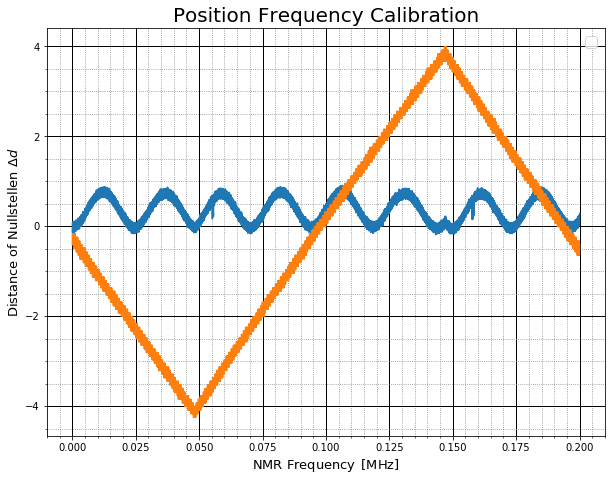

In [13]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(calib[0][1:],calib[2][1:])
plt.plot(calib[0][1:],calib[1][1:])

###   Label / Title

plt.ylabel(r'Voltage$\,[\mathrm{V}]$', fontsize=13)
plt.xlabel(r'Time$\,[\mathrm{s}]$', fontsize=13)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([18.97,19.3])
#axes.set_ylim([-300,370])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(fontsize=15)
#plt.savefig('Eichung.png')
plt.show()

# Loop Stuff

In [14]:
#Widerstand 1
#data_1_2_1 = csvReader('r1_2_1_HM1508-2.csv')
data_1_5_1 = csvReader('r1_5_1_HM1508-2.csv')
data_1_5_2 = csvReader('r1_5_2_HM1508-2.csv')
data_1_5_3 = csvReader('r1_5_3_HM1508-2.csv')
data_1_5_4 = csvReader('r1_5_4_HM1508-2.csv')
data_1_10_1 = csvReader('r1_10_1_HM1508-2.csv')
data_1_10_2 = csvReader('r1_10_2_HM1508-2.csv')
data_1_10_3 = csvReader('r1_10_3_HM1508-2.csv')
data_1_10_4 = csvReader('r1_10_4_HM1508-2.csv')
data_1 = [data_1_5_1,data_1_5_2,data_1_5_3,data_1_5_4,data_1_10_1,data_1_10_2,data_1_10_3,data_1_10_4]
#WIderstand 2
#data_2_2_1 = csvReader('r2_2_1_HM1508-2.csv')
#data_2_2_2 = csvReader('r2_2_2_HM1508-2.csv')
data_2_5_1 = csvReader('r2_5_1_HM1508-2.csv')
data_2_5_2 = csvReader('r2_5_2_HM1508-2.csv')
data_2_5_3 = csvReader('r2_5_3_HM1508-2.csv')
data_2_5_4 = csvReader('r2_5_4_HM1508-2.csv')
data_2_10_1 = csvReader('r2_10_1_HM1508-2.csv')
data_2_10_2 = csvReader('r2_10_2_HM1508-2.csv')
data_2_10_3 = csvReader('r2_10_3_HM1508-2.csv')
data_2 = [data_2_5_1,data_2_5_2,data_2_5_3,data_2_5_4,data_2_10_1,data_2_10_2,data_2_10_3]
#WIderstand 3
data_3_5_1 = csvReader('r3_5_1_HM1508-2.csv')
data_3_5_2 = csvReader('r3_5_2_HM1508-2.csv')
data_3_10_1 = csvReader('r3_10_1_HM1508-2.csv')
data_3_10_2 = csvReader('r2_10_2_HM1508-2.csv')
data_3_10_3 = csvReader('r3_10_3_HM1508-2.csv')
data_3 = [data_3_5_1,data_3_5_2,data_3_10_1,data_3_10_2,data_3_10_3]
#WIderstand 4
data_4_5_1 = csvReader('r4_5_1_HM1508-2.csv')
data_4_5_2 = csvReader('r4_5_2_HM1508-2.csv')
data_4_10_1 = csvReader('r4_10_1_HM1508-2.csv')
data_4_10_2 = csvReader('r4_10_2_HM1508-2.csv')
data_4_10_3 = csvReader('r4_10_3_HM1508-2.csv')
data_4 = [data_4_5_1,data_4_5_2,data_4_10_1,data_4_10_2,data_4_10_3]
#WIderstand 5
data_5_5_1 = csvReader('r5_5_1_HM1508-2.csv')
data_5_5_2 = csvReader('r5_5_2_HM1508-2.csv')
data_5_5_3 = csvReader('r5_5_3_HM1508-2.csv')
data_5_10_1 = csvReader('r5_10_1_HM1508-2.csv')
data_5_10_2 = csvReader('r5_10_2_HM1508-2.csv')
data_5_10_3 = csvReader('r5_10_3_HM1508-2.csv')
data_5 = [data_5_5_1,data_5_5_2,data_5_5_3,data_5_10_1,data_5_10_2,data_5_10_3]

In [15]:
Test1 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
r1_5_1 = Squid(data_1[0], [-0.3,0.4,0.5,0], 'r1_5_1', Test1)
r1_5_2 = Squid(data_1[1], [-0.3,0.4,0.5,0], 'r1_5_2', Test1)
r1_5_3 = Squid(data_1[2], [-0.4,0.2,0.4,0], 'r1_5_3', Test1)
r1_5_4 = Squid(data_1[3], [-0.3,0.3,0.4,2], 'r1_5_4', Test1)
r1_10_1 = Squid(data_1[4], [-0.3,0.3,0.8,2], 'r1_10_1', Test1,end=1610)
r1_10_2 = Squid(data_1[5], [-0.3,0.3,0.8,2], 'r1_10_2', Test1)
r1_10_3 = Squid(data_1[6], [-0.3,0.3,0.8,2], 'r1_10_3', Test1)
r1_10_4 = Squid(data_1[7], [-0.3,0.3,0.8,2], 'r1_10_4', Test1)

In [16]:
Test2 = (False,False)
r2_5_1 = Squid(data_2[0], [-0.4,0.2,0.4,10], 'r2_5_1', Test2)
r2_5_2 = Squid(data_2[1], [-0.4,0.2,0.4,10], 'r2_5_2', Test2)
r2_5_3 = Squid(data_2[2], [-0.4,0.2,0.4,10], 'r2_5_3', Test2)
r2_5_4 = Squid(data_2[3], [-0.4,0.2,0.4,10], 'r2_5_4', Test2)
r2_10_1 = Squid(data_2[4], [0.9,0.2,0.9,2], 'r2_10_1', Test2, start=110)
r2_10_2 = Squid(data_2[5], [-0.4,0.2,0.9,10], 'r2_10_2', Test2)
r2_10_3 = Squid(data_2[6], [-0.4,0.2,0.8,10], 'r2_10_3', Test2, end=1575)

In [17]:
Test3 = (False,False)
r3_5_1 = Squid(data_3[0], [-0.4,0.2,0.4,10], 'r3_5_1', Test3,end=1055)
r3_5_2 = Squid(data_3[1], [-0.4,0.2,0.4,10], 'r3_5_2', Test3, start=11, end=1010)
r3_10_1 = Squid(data_3[2], [0.9,0.2,0.9,2], 'r3_10_1', Test3)
###r3_10_2 = Squid(data_3[3], [-0.4,0.2,0.9,10], 'r3_10_2', Test3) TOT wahrscheinlich etwas falsch gemacht
r3_10_3 = Squid(data_3[4], [-0.4,0.2,0.8,10], 'r3_10_3', Test3,start=320)

In [18]:
Test4 = (False,False)
r4_5_1 = Squid(data_4[0], [-0.4,0.2,0.4,10], 'r4_5_1', Test4)
r4_5_2 = Squid(data_4[1], [-0.4,0.2,0.4,10], 'r4_5_2', Test4, end=1270)
r4_10_1 = Squid(data_4[2], [0.9,0.2,0.9,2], 'r4_10_1', Test4)
r4_10_2 = Squid(data_4[3], [-0.4,0.2,0.9,10], 'r4_10_2', Test4)
r4_10_3 = Squid(data_4[4], [-0.4,0.2,0.8,10], 'r4_10_3', Test4, end=1140)

In [19]:
Test5 = (False,False)
###r5_5_1 = Squid(data_5[0], [-0.4,0.2,0.4,10], 'r5_5_1TOT', Test5) Tot
r5_5_2 = Squid(data_5[1], [-0.4,0.2,0.4,10], 'r5_5_2', Test5)
r5_5_3 = Squid(data_5[2], [-0.4,0.2,0.4,10], 'r5_5_3', Test5)
r5_10_1 = Squid(data_5[3], [0.9,0.2,0.9,2], 'r5_10_1', Test5,start=100,end=1400)
r5_10_2 = Squid(data_5[4], [-0.4,0.2,0.9,10], 'r5_10_2', Test5,start=400)
###r5_10_3 = Squid(data_5[5], [-0.4,0.2,0.8,10], 'r5_10_3TOT', Test5) Tot

In [20]:
#Spannung DeltaV Loop 1
#print(r1_5_1[0][1],'\n',r1_5_2[0][1],'\n',r1_5_3[0][1],'\n',r1_5_4[0][1],'\n',r1_10_1[0][1],'\n',r1_10_2[0][1],'\n',r1_10_3[0][1],'\n',r1_10_4[0][1])
ULoop_1 = [r1_5_1[0][1],r1_5_2[0][1],r1_5_3[0][1],r1_5_4[0][1],abs(r1_10_1[0][1]),abs(r1_10_2[0][1]),r1_10_3[0][1],r1_10_4[0][1]]
V_1 = gmean(ULoop_1, uncertainties=True)
print('{:L}'.format(gmean(ULoop_1, uncertainties=True)))

0.2407 \pm 0.0007


In [21]:
#Spannung DeltaV Loop 2
#print(r2_5_1[0][1],'\n',r2_5_2[0][1],'\n',r2_5_3[0][1],'\n',r2_5_4[0][1],'\n',r2_10_1[0][1],'\n',r2_10_2[0][1],'\n',r2_10_3[0][1])
ULoop_2 = [r2_5_1[0][1],r2_5_2[0][1],abs(r2_5_3[0][1]),abs(r2_5_4[0][1]),abs(r2_10_1[0][1]),abs(r2_10_2[0][1]),abs(r2_10_3[0][1])]
V_2 = gmean(ULoop_2, uncertainties=True)
print('{:L}'.format(gmean(ULoop_2, uncertainties=True)))

0.1298 \pm 0.0007


In [22]:
#Spannung DeltaV Loop 3
#print(r3_5_1[0][1],'\n',r3_5_2[0][1],'\n',r3_10_1[0][1],'\n',r3_10_3[0][1])
ULoop_3 = [r3_5_1[0][1],r3_5_2[0][1],abs(r3_10_1[0][1]),abs(r3_10_3[0][1])]
V_3 = gmean(ULoop_3, uncertainties=True)
print('{:L}'.format(gmean(ULoop_3, uncertainties=True)))

0.0426 \pm 0.0008


In [23]:
#Spannung DeltaV Loop 4
#print(r4_5_1[0][1],'\n',r4_5_2[0][1],'\n',r4_10_1[0][1],'\n',r4_10_2[0][1],'\n',r4_10_3[0][1])
ULoop_4 = [abs(r4_5_1[0][1]),abs(r4_5_2[0][1]),abs(r4_10_1[0][1]),abs(r4_10_2[0][1]),abs(r4_10_3[0][1])]
V_4 = gmean(ULoop_4, uncertainties=True)
print('{:L}'.format(gmean(ULoop_4, uncertainties=True)))

0.0259 \pm 0.0005


In [24]:
#Spannung DeltaV Loop 5
#print(r5_5_2[0][1],'\n',r5_5_3[0][1],'\n',r5_10_1[0][1],'\n',r5_10_2[0][1])
ULoop_5 = [abs(r5_5_2[0][1]),abs(r5_10_1[0][1]),abs(r5_10_2[0][1])]
V_5 = gmean(ULoop_5, uncertainties=True)
print('{:L}'.format(gmean(ULoop_5, uncertainties=True)))

0.0150 \pm 0.0006


In [25]:
#B_z-Feld
F = 9.3*10**-9 #T/Phi
s_i = 950*10**-3 #V/Phi
Bz_1 = (F * V_1) / s_i
Bz_2 = (F * V_2) / s_i
Bz_3 = (F * V_3) / s_i
Bz_4 = (F * V_4) / s_i
Bz_5 = (F * V_5) / s_i
print('{:L}'.format(Bz_1),'\n','{:L}'.format(Bz_2),'\n','{:L}'.format(Bz_3),'\n','{:L}'.format(Bz_4),'\n','{:L}'.format(Bz_5),'\n')

\left(2.356 \pm 0.007\right) \times 10^{-9} 
 \left(1.271 \pm 0.007\right) \times 10^{-9} 
 \left(4.17 \pm 0.08\right) \times 10^{-10} 
 \left(2.54 \pm 0.05\right) \times 10^{-10} 
 \left(1.47 \pm 0.06\right) \times 10^{-10} 



In [26]:
#Dipolmoment 
µ0 = 1.25667062*10**-6
d_sp_SI =  d_sp * 10**-2
p_1 = (Bz_1 * (d_sp_SI)**3 * 2 * pi) / (µ0)
p_2 = (Bz_2 * (d_sp_SI)**3 * 2 * pi) / (µ0)
p_3 = (Bz_3 * (d_sp_SI)**3 * 2 * pi) / (µ0)
p_4 = (Bz_4 * (d_sp_SI)**3 * 2 * pi) / (µ0)
p_5 = (Bz_5 * (d_sp_SI)**3 * 2 * pi) / (µ0)
print('{:L}'.format(p_1),'\n','{:L}'.format(p_2),'\n','{:L}'.format(p_3),'\n','{:L}'.format(p_4),'\n','{:L}'.format(p_5),'\n')

\left(2.19 \pm 0.29\right) \times 10^{-7} 
 \left(1.18 \pm 0.15\right) \times 10^{-7} 
 \left(3.9 \pm 0.5\right) \times 10^{-8} 
 \left(2.36 \pm 0.31\right) \times 10^{-8} 
 \left(1.37 \pm 0.19\right) \times 10^{-8} 



In [27]:
#Dipolmoment 2
vier = 1
r_Loop_SI = r_Loop*10**-3
p = (2 * pi * (r_Loop_SI)**2 * U_B) / (vier*R_S)
print('{:L}'.format(p[0][0]),'\n','{:L}'.format(p[0][1]),'\n','{:L}'.format(p[0][2]),'\n','{:L}'.format(p[0][3]),'\n','{:L}'.format(p[0][4]),'\n')

\left(8.75 \pm 0.11\right) \times 10^{-7} 
 \left(4.47 \pm 0.06\right) \times 10^{-7} 
 \left(1.498 \pm 0.020\right) \times 10^{-7} 
 \left(8.82 \pm 0.12\right) \times 10^{-8} 
 \left(4.51 \pm 0.06\right) \times 10^{-8} 



In [28]:
#B_z-Feld 2

Bz = (µ0 * p) / ((d_sp_SI)**3 * 2 * pi)
for i in range(len(Bz[0])):
    print('{:L}'.format((Bz[0][i])))

\left(9.4 \pm 1.2\right) \times 10^{-9}
\left(4.8 \pm 0.6\right) \times 10^{-9}
\left(1.61 \pm 0.21\right) \times 10^{-9}
\left(9.5 \pm 1.2\right) \times 10^{-10}
\left(4.8 \pm 0.6\right) \times 10^{-10}


In [29]:
#Vergleich Dipol
t_1 = (p[0][0].nominal_value-p_1.nominal_value)/(p[0][0].std_dev-p_1.std_dev)
t_2 = (p[0][1].nominal_value-p_2.nominal_value)/(p[0][1].std_dev-p_2.std_dev)
t_3 = (p[0][2].nominal_value-p_3.nominal_value)/(p[0][2].std_dev-p_3.std_dev)
t_4 = (p[0][3].nominal_value-p_4.nominal_value)/(p[0][3].std_dev-p_4.std_dev)
t_5 = (p[0][4].nominal_value-p_5.nominal_value)/(p[0][4].std_dev-p_5.std_dev)
print(t_1,'\n',t_2,'\n',t_3,'\n',t_4,'\n',t_5)

-38.22543024101681 
 -34.26320264248762 
 -35.13807678081069 
 -32.88988471754997 
 -24.39982346452998


In [30]:
x_test = arange(0,100,0.1)
r2_5_1[0][0].nominal_value
#plt.plot(x_test, p0[0] + p0[1] * sin(p0[2] * x_test + p0[3]),label='test')

-0.42570908027286675

# Polardarstellung

In [31]:
def sinus(x,b,c,d):
    return b*sin(x*c+d)

In [32]:
def Polar(x,p0,Titel=None, start=1, end=None, Test=None):
    F = 9.3*10**-9 #T/Phi
    s_i = 950*10**-3 #V/Phi
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 7.5
    plt.rcParams["figure.figsize"] = fig_size
    
    #Only Partly Needed für c und d
    
    xnew = arange(0,100,0.01)
    p = Squidfit_pm(x[0][1:],x[1][1:],p0)
    b = p[0][1].nominal_value
    c = p[0][2].nominal_value
    d = p[0][3].nominal_value
    ynew = sinus(xnew,b,c,d)
    for i in range((len(ynew))):
        if ynew[i] > 0 and ynew[i+1] < 0:
            if abs(ynew[i]) < abs(ynew[i+1]):
                minimum = ynew[i]  #mim´nimum enstpricht nullstelle
            else:
                minimum = ynew[i+1]
            break
        else:
            None
    print(minimum)
    k1 = np.where(ynew == minimum)
    k1 = k1[0][0]+1
    print(k1)
    xnew = xnew[k1:]
    ynew = ynew[k1:]
    for i in range((len(ynew))):
        if ynew[i] > 0 and ynew[i+1] < 0:
            if abs(ynew[i]) < abs(ynew[i+1]):
                minimum = ynew[i]
            else:
                minimum = ynew[i+1]
            break
        else:
            None
    k1 = np.where(ynew == minimum)
    k1 = k1[0][0]
    print(k1)
    xnew = xnew[:k1]
    ynew = ynew[:k1]
    
    
    # Eingetliche Funktion
    Bz = np.array(x[1][start:end]) * (F/s_i)
    angle = c * np.array(x[0][start:end]) - d
    Polx = abs(Bz*10**9)*cos(angle)
    Poly = abs(Bz*10**9)*sin(angle)
    plt.plot(Polx,Poly,label='Data Points in Polar Representation')


    ###   Label / Title

    plt.ylabel(r'Bz $\,[\mathrm{nT}]$', fontsize=13)
    plt.xlabel(r'Bz $\,[\mathrm{nT}]$', fontsize=13)
    #plt.title('Polar Representation', fontsize=20)

    ###   Axes / Grid

    axes = plt.gca()  ##  Searches current Axes

    #axes.set_xlim([18.97,19.3])
    #axes.set_ylim([-300,370])

    #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
    #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

    axes.grid(which='major', linestyle='-', linewidth='1', color='black')
    axes.grid(which='minor', linestyle=':', color='gray')
    axes.minorticks_on()

    plt.legend(fontsize=15)
    plt.savefig(Titel)
    plt.show()

# Andere Proben

In [33]:
#Probe 1
data_P1_1 = csvReader('probe1_10_1_HM1508-2.csv')
data_P1_2 = csvReader('probe1_10_2_HM1508-2.csv')
data_P1_3 = csvReader('probe1_10_3_HM1508-2.csv')
data_P1_4 = csvReader('probe1_10_4_HM1508-2.csv')
#Probe 2
data_P2_1 = csvReader('probe2_10_1_HM1508-2.csv')
data_P2_2 = csvReader('probe2_10_2_HM1508-2.csv')
#Probe 3
data_P3_1 = csvReader('probe3_10_1_HM1508-2.csv')
data_P3_2 = csvReader('probe3_10_2_HM1508-2.csv')
data_P3_3 = csvReader('probe3_10_3_HM1508-2.csv')
data_P3_4 = csvReader('probe3_10_4_HM1508-2.csv')
#Probe 4
data_P4_1 = csvReader('probe4_10_1_HM1508-2.csv')
data_P4_2 = csvReader('probe4_10_2_HM1508-2.csv')
data_P4_3 = csvReader('probe4_10_3_HM1508-2.csv')
data_P4_4 = csvReader('probe4_10_4_HM1508-2.csv')
#Probe 5
data_P5_1 = csvReader('probe5_10_1_HM1508-2.csv')
data_P5_2 = csvReader('probe5_10_2_HM1508-2.csv')
data_P5_3 = csvReader('probe5_10_3_HM1508-2.csv')
data_P5_4 = csvReader('probe5_10_4_HM1508-2.csv')
data_P5_5 = csvReader('probe5_10_5_HM1508-2.csv')

In [34]:
Test6 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
data_P1_1_pm = Squid(data_P1_1, [-0.3,0.1,0.9,0], 'P1_1', Test6)
data_P1_2_pm = Squid(data_P1_2, [-0.3,0.4,0.9,0], 'P1_2', Test6)
data_P1_3_pm = Squid(data_P1_3, [-0.4,0.2,0.9,0], 'P1_3', Test6)
data_P1_4_pm = Squid(data_P1_4, [-0.4,0.2,0.9,0], 'P1_4', Test6)

In [35]:
Test7 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
data_P2_1_pm = Squid(data_P2_1, [-0.3,0.4,0.8,0], 'P2_1', Test7)
data_P2_2_pm = Squid(data_P2_2, [-0.3,0.4,0.8,0], 'P2_2', Test7,end=990)

In [36]:
Test8 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
data_P3_1_pm = Squid(data_P3_1, [-0.3,0.4,0.5,0], 'P3_1', Test8)
data_P3_2_pm = Squid(data_P3_2, [-0.3,0.4,0.5,0], 'P3_2', Test8)
data_P3_3_pm = Squid(data_P3_3, [-0.4,5,0.9,0], 'P3_3', Test8)
data_P3_4_pm = Squid(data_P3_4, [-0.4,5,0.9,0], 'P3_4', Test8)

In [44]:
Test9 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
data_P4_1_pm = Squid(data_P4_1, [0,0.005,1.8,0], 'P4_1', Test9,start=200)
data_P4_2_pm = Squid(data_P4_2, [0,0.005,1.8,0], 'P4_2', Test9)
data_P4_3_pm = Squid(data_P4_3, [0,0.05,1.8,0], 'P4_3', Test9)
###data_P4_4_pm = Squid(data_P4_4, [0,0.05,0.8,0], 'P4_4', Test9)

In [45]:
Test10 = (False,False) #Test1[0] ist test option und Test1[1] ist Bilder an aus.
data_P5_1_pm = Squid(data_P5_1, [-5,10,1,0], 'P5_1', Test10)
data_P5_2_pm = Squid(data_P5_2, [-5,10,1,0], 'P5_2', Test10)
data_P5_3_pm = Squid(data_P5_3, [-5,10,0.9,0], 'P5_3', Test10)
data_P5_4_pm = Squid(data_P5_4, [-5,9,0.8,0], 'P5_4', Test10)
data_P5_5_pm = Squid(data_P5_5, [-5,10,0.9,0], '5_5', Test10)

In [46]:
#Probe 1 SPannung
#print(data_P1_1_pm[0][1],'\n',data_P1_2_pm[0][1],'\n',data_P1_3_pm[0][1],'\n',data_P1_4_pm[0][1])
UProbe_1 = [abs(data_P1_1_pm[0][1]),abs(data_P1_2_pm[0][1]),abs(data_P1_3_pm[0][1]),abs(data_P1_4_pm[0][1])]
PV_1 = gmean(UProbe_1, uncertainties=True)
print('{:L}'.format(gmean(UProbe_1, uncertainties=True)))

0.0202 \pm 0.0007


In [47]:
#Probe 2 SPannung
#print(data_P2_1_pm[0][1],'\n',data_P2_2_pm[0][1])
UProbe_2 = [abs(data_P2_1_pm[0][1]),abs(data_P2_2_pm[0][1])]
PV_2 = gmean(UProbe_2, uncertainties=True)
print('{:L}'.format(gmean(UProbe_2, uncertainties=True)))

0.0349 \pm 0.0012


In [48]:
#Probe 3 SPannung
#print(data_P3_1_pm[0][1],'\n',data_P3_2_pm[0][1],'\n',data_P3_3_pm[0][1],'\n',data_P3_4_pm[0][1])
UProbe_3 = [abs(data_P3_1_pm[0][1]),abs(data_P3_2_pm[0][1]),abs(data_P3_3_pm[0][1]),abs(data_P3_4_pm[0][1])]
PV_3 = gmean(UProbe_3, uncertainties=True)
print('{:L}'.format(gmean(UProbe_3, uncertainties=True)))

8.589 \pm 0.031


In [53]:
#Probe 4 SPannung
#print(data_P4_1_pm[0][1],'\n',data_P4_2_pm[0][1],'\n',data_P4_3_pm[0][1])
UProbe_4 = [abs(data_P4_1_pm[0][1]),abs(data_P4_2_pm[0][1]),abs(data_P4_3_pm[0][1])]
PV_4 = gmean(UProbe_4, uncertainties=True)
print('{:L}'.format(gmean(UProbe_4, uncertainties=True)))

0.00081 \pm 0.00005


In [54]:
#Probe 5 SPannung
#print(data_P5_2_pm[0][1],'\n',data_P5_3_pm[0][1],'\n',data_P5_4_pm[0][1],'\n',data_P5_5_pm[0][1])
UProbe_5 = [abs(data_P5_2_pm[0][1]),abs(data_P5_3_pm[0][1]),abs(data_P5_4_pm[0][1]),abs(data_P5_5_pm[0][1])]
PV_5 = gmean(UProbe_5, uncertainties=True)
print('{:L}'.format(gmean(UProbe_5, uncertainties=True)))

6.355 \pm 0.031


In [55]:
#B_z-Feld Proben
F = 9.3*10**-9 #T/Phi
s_i = 950*10**-3 #V/Phi
s_i2 = 21*10**-3 #V/Phi
PBz_1 = (F * PV_1) / s_i
PBz_2 = (F * PV_2) / s_i
PBz_3 = (F * PV_3) / s_i
PBz_4 = (F * PV_4) / s_i
PBz_5 = (F * PV_5) / s_i2
print('{:L}'.format(PBz_1),'\n','{:L}'.format(PBz_2),'\n','{:L}'.format(PBz_3),'\n','{:L}'.format(PBz_4),'\n','{:L}'.format(PBz_5),'\n')

\left(1.98 \pm 0.07\right) \times 10^{-10} 
 \left(3.42 \pm 0.12\right) \times 10^{-10} 
 \left(8.408 \pm 0.030\right) \times 10^{-8} 
 \left(7.9 \pm 0.5\right) \times 10^{-12} 
 \left(2.814 \pm 0.014\right) \times 10^{-6} 



In [56]:
#Dipolmoment Proben
µ0 = 1.25667062*10**-6
d_sp_SI =  d_sp * 10**-2
Pp_1 = (PBz_1 * (d_sp_SI)**3 * 2 * pi) / (µ0)
Pp_2 = (PBz_2 * (d_sp_SI)**3 * 2 * pi) / (µ0)
Pp_3 = (PBz_3 * (d_sp_SI)**3 * 2 * pi) / (µ0)
Pp_4 = (PBz_4 * (d_sp_SI)**3 * 2 * pi) / (µ0)
Pp_5 = (PBz_5 * (d_sp_SI)**3 * 2 * pi) / (µ0)
print('{:L}'.format(Pp_1),'\n','{:L}'.format(Pp_2),'\n','{:L}'.format(Pp_3),'\n','{:L}'.format(Pp_4),'\n','{:L}'.format(Pp_5),'\n')

\left(1.84 \pm 0.25\right) \times 10^{-8} 
 \left(3.2 \pm 0.4\right) \times 10^{-8} 
 \left(7.8 \pm 1.0\right) \times 10^{-6} 
 \left(7.4 \pm 1.1\right) \times 10^{-10} 
 0.000262 \pm 0.000034 

